In [1]:
import torch
import torch.optim as optim
import torch.nn as nn

import numpy as np
from numpy import linalg as LA
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage.filters import window

import os

from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# define functions

# CUDA usage
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Data path
data_path = '/content/gdrive/My Drive/SENSE/'
# data_path = './data/'

# 2D Fourier Transform (Numpy)
def ft2_np(data):
    nx,ny = data.shape[:2]
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(data),axes=(0,1))) / np.sqrt(nx*ny)

# 2D Inverse Fourier Transform (Numpy)
def ift2_np(data):
    nx,ny = data.shape[:2]
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(data),axes=(0,1))) * np.sqrt(nx*ny)

# display an image
def showImg(img, name='',v_min=0, v_max=6e-2,c_map='gray'):
    plt.axis('off')
#     plt.axis('equal')
    plt.tight_layout()
    if len(name) >0:
        plt.title(name)
    plt.imshow(img, cmap= c_map,vmin = v_min, vmax=v_max)

# display multiple images (x,y,num_image)
def display_all(img,v_min=0, v_max=6e-2):
    if img.ndim < 3:
        showImg(img)
    else:
        num_img = img.shape[2]
        num_rows = int(np.floor(np.sqrt(num_img)))
        num_cols = int(np.ceil( num_img / num_rows ))

        for k in range(num_img):
            plt.subplot(num_rows,num_cols, k+1)
            showImg(img[:,:,k],v_min=v_min,v_max=v_max)
            if k+1 == num_cols:
                plt.show()
    plt.show()


def show_results(img, title=''):
    print(title)
    plt.subplot(131), showImg(abs(img), name = 'Magnitude')
    plt.subplot(132), showImg(np.angle(img),v_min = -np.pi , v_max = np.pi, name = 'Phase(angle)')
    plt.subplot(133), showImg(abs(ft2_np(img)), v_max=1e-2, name = 'k-space')
    plt.show()

Using cuda device


Data Load

In [3]:
# Coil sensitivity
coil_sens = sio.loadmat(data_path + 'test_kspace.mat')['coil_sens']

# Raw k-space data
kData = sio.loadmat(data_path+'test_kspace.mat')['kData']
kData = kData / np.max(abs(kData))      # Normalize to [0 1]


# Data size (32 channels)
nx, ny, nc = kData.shape

print('Image Dimensions: ',nx, ny, nc)



Image Dimensions:  234 256 20


Gold Standard


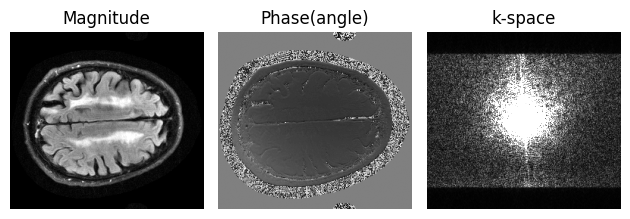

In [4]:
# Gold Standard (ideal) images
ideal = (coil_sens.conj()*ift2_np( kData )).sum(2) / ((abs(coil_sens)**2).sum(2)+np.finfo(float).eps);

show_results(ideal, 'Gold Standard')




Partial Fourier
Sampling Mask

(234, 256, 1)
acc: 4.775510204081633x
Sampling Masks


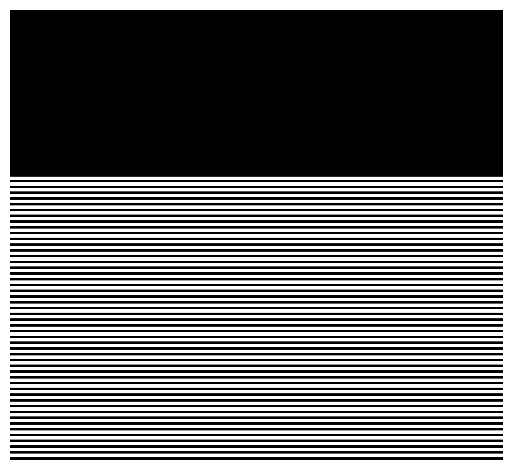

In [5]:
# Sampling Mask
kMask = sio.loadmat(data_path + 'test_kMask.mat')['kMask']
kMask = kMask[..., np.newaxis]
print(kMask.shape)

acc = np.prod(kMask.shape) / kMask.sum()
print('acc: ' + str(acc) + 'x')


print('Sampling Masks')
showImg(kMask,v_max = 0.1)



In [6]:
# transform to torch data format
coilc = torch.tensor(coil_sens.transpose(2,0,1),dtype = torch.cfloat).to(device) # S (sensitivity map)
datc = torch.tensor((kData*kMask).transpose(2,0,1),dtype=torch.cfloat)[None,...].to(device) # y (얻은 데이터)
maskc = torch.tensor(kMask.transpose(2,0,1),dtype=torch.cfloat)[None,...].to(device) # U (1/0 map)

print(f"coilc.shape {coilc.shape}")
print(f"datc.shape {datc.shape}")
print(f"maskc.shape {maskc.shape}")

# 2D Fourier (torch)
def ft2c(x):
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(x), dim = (-1,-2), norm = "ortho"))

# 2D Inverse Fourier (torch)
def ift2c(x):
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(x), dim = (-1,-2), norm = "ortho"))

# Forward model
def Ac(x): # Ax = UFSx
    return maskc * ft2c(coilc * x)

# Its Hermitian
def Ahc(x):
    return (torch.conj(coilc)*ift2c(maskc*x)).sum(1)

# Inner product
def inner_c(x,y):
    return (torch.conj(x) * y).sum(list(range(1,x.dim())) )

# MSE Loss
MSE = nn.MSELoss()

# MSE for complex tensors
def MSEc(x, y):
    return MSE(torch.view_as_real(x), torch.view_as_real(y))

coilc.shape torch.Size([20, 234, 256])
datc.shape torch.Size([1, 20, 234, 256])
maskc.shape torch.Size([1, 1, 234, 256])


CG-SENSE

r torch.Size([1, 234, 256])
iter 0 , residue 0.50571936
iter 10 , residue 0.012322731
iter 20 , residue 0.0025371998
iter 30 , residue 0.0028811023
iter 40 , residue 0.0021757912
CG-SENSE


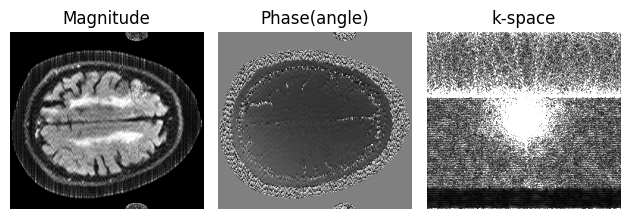

Error: 0.31104044426137095


In [7]:
# CG-SENSE
# x = Ahc(datc).to(device)
x = torch.zeros([1,1,nx,ny]).to(device)


r = Ahc(datc) - Ahc(Ac(x)) # y - UFSx
print(f"r {r.shape}")
p = r # residue Matrix
rsold = torch.norm(r, 'fro') **2


for it in range(50): # Training x
    z = Ahc(Ac(p))
    alpha = rsold / inner_c(p, z)
    x = x + alpha * p
    r = r - alpha * z
    rsnew = torch.norm(r, 'fro')**2

    if (it) % 10 == 0:
        print('iter', it, ', residue',np.sqrt(rsnew.cpu().numpy()))

    if torch.sqrt(rsnew) < 1e-6:
        break
    p = r + (rsnew / rsold) * p
    rsold = rsnew

recon = x.squeeze().cpu().numpy()
sense = recon


show_results(sense, 'CG-SENSE')

sio.savemat(data_path + 'FAST_MR_sense.mat', {'image': sense})


# error
NRMSE = LA.norm(ideal - sense) / LA.norm(ideal)
print("Error:", NRMSE)

Phase Estimation

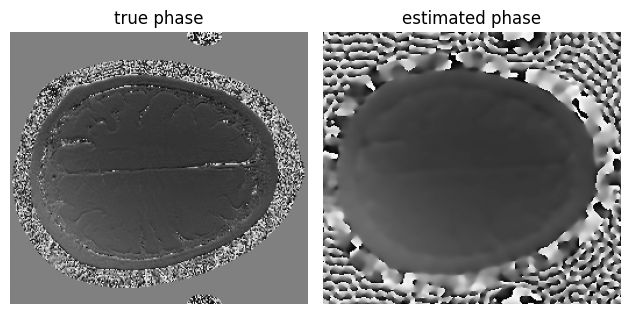

In [8]:
# Phase estimation

def phase_estimation(img, nx_ac=32, ny_ac=32):
    nx,ny = img.shape[:2]

    x_ac_idx_bgn = (nx//2)+1 - (nx_ac//2)-1
    x_ac_idx_end = (nx//2)+1 + (nx_ac//2) - ((nx_ac+1)%2)
    y_ac_idx_bgn = (ny//2)+1 - (ny_ac//2)-1
    y_ac_idx_end = (ny//2)+1 + (ny_ac//2) - ((ny_ac+1)%2)

    acs_mask = np.zeros((nx,ny))
    acs_mask[x_ac_idx_bgn:x_ac_idx_end,y_ac_idx_bgn:y_ac_idx_end] = np.ones([nx_ac, ny_ac]) * window('hamming', (nx_ac,ny_ac))

    kspace = ft2_np(img)

    acs = kspace * acs_mask
    low_res_img = ift2_np(acs)


    return np.exp(1j * np.angle(low_res_img) )


# Estimated Phase
Pe = phase_estimation(sense, nx_ac=64,ny_ac=64)
Pc = torch.tensor((Pe),dtype=torch.cfloat)[None,None,...].to(device)

# Display
plt.subplot(121), showImg(np.angle(ideal), v_min=-np.pi, v_max=np.pi, name='true phase')
plt.subplot(122), showImg(np.angle(Pe), v_min=-np.pi, v_max=np.pi, name ='estimated phase')
plt.show()


VCC-SENSE
torch.Size([1, 234, 256])
iter 0 , residue 0.79816014
iter 10 , residue 0.011422495
iter 20 , residue 0.004025387
iter 30 , residue 0.0018063439
iter 40 , residue 0.0013026234
Error: 0.1896618097916047
VCC-SENSE


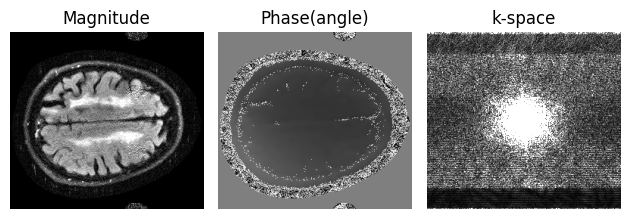

In [9]:
# VCC-SENSE

flip_maskc = maskc.flip([-1,-2]).roll([(nx+1)%2, (ny+1)%2], dims=(-1,-2))
datc_vcc = torch.cat((datc, datc.conj().flip([-1,-2]).roll([(nx+1)%2, (ny+1)%2], dims=(-1,-2))  ), dim=1)


def Ac_vcc(x):
    y1 = maskc * ft2c(coilc * x)
    y2 = flip_maskc * ft2c( coilc.conj() * Pc.conj()**2 * x)

    return torch.cat((y1,y2), dim=1)

# Its Hermitian
def Ahc_vcc(x):
    y1 = x[:,:nc]
    y2 = x[:,nc:]

    z1 = (torch.conj(coilc)*ift2c(maskc*y1)).sum(1)
    z2 = (Pc**2 * coilc*ift2c(flip_maskc*y2)).sum(1)

    return z1 + z2


print('VCC-SENSE')


x = torch.zeros([1,1,nx,ny]).to(device)

r = Ahc_vcc(datc_vcc) - Ahc_vcc(Ac_vcc(x)) # y - UFSx
print(r.shape)
p = r
rsold = torch.norm(r, 'fro') **2


for it in range(50): # Training x
    z = Ahc_vcc(Ac_vcc(p))
    alpha = rsold / inner_c(p, z)
    x = x + alpha * p
    r = r - alpha * z
    rsnew = torch.norm(r, 'fro')**2

    if (it) % 10 == 0:
        print('iter', it, ', residue',np.sqrt(rsnew.cpu().numpy()))

    if torch.sqrt(rsnew) < 1e-6:
        break
    p = r + (rsnew / rsold) * p
    rsold = rsnew


recon = x.squeeze().cpu().numpy()
vcc_sense = recon

NRMSE = LA.norm(ideal - vcc_sense) / LA.norm(ideal)
print("Error:", NRMSE)

show_results(vcc_sense, 'VCC-SENSE')

# Generative Untrained Network

In [10]:
class GenNet(nn.Module):
    def __init__(self, in_channels=24, out_channels=2):
        super(GenNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1, bias=False))

        self.layer2 = nn.Sequential(
            nn.Conv2d(48, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1, bias=False))

        self.layer3 = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1, bias=False))

        self.layer4 = nn.Sequential(
            nn.Conv2d(96 , 64, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1, bias=False))

        # Initialize weights
        self._init_weights()


    def _init_weights(self): # When using ConvTranspose2d, Conv2D, Utilize He initialization
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                # m.bias.data.zero_()


    def forward(self, x):
        upsample5 = self.layer1(x)
        upsample4 = self.layer2(upsample5)
        upsample3 = self.layer3(upsample4)
        upsample2 = self.layer3(upsample3)
        upsample1 = self.layer3(upsample2)
        upsample0 = self.layer4(upsample1)

        out_H, out_W = x.size(-2)*32, x.size(-1)*32
        return upsample0[:,:,(out_H - nx)//2:out_H-((out_H - nx)//2 + nx%2),(out_W - ny)//2:out_W-((out_W - ny)//2+ny%2)] # Central Crop Image into size of (nx, ny)

In [11]:
def run_GenNet(model,input,cur_recon, iterations = 5001,lr=1e-3):

    target = torch.view_as_real(torch.tensor(cur_recon,dtype = torch.cfloat)) # target SHAPE = (206, 176, 1, 2)
    target = torch.cat((target[...,0],target[...,1]),dim=-1).permute(2,0,1)[None].to(device)

    x = input.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for k in range(iterations):
        optimizer.zero_grad()

        a = model(x)
        loss = MSE(a, target)

        if k%1000 == 0:
            print('     iter',k,', loss: ' + str(loss.cpu().detach().numpy()))

        loss.backward()
        optimizer.step()


    ti = a[0].detach().permute(1,2,0).cpu().numpy()
    tmp= ti[...,:1] + 1j*ti[...,1:] # Convert back to complex form
    rec = torch.tensor(tmp).permute(2,0,1)[None].cuda()

    return rec, loss.cpu().detach().numpy()


# VCC Deep Generative Untrained Prior (Proposed)

VCC-SENSE
torch.Size([1, 234, 256])
iter 0 , residue 0.79816014
iter 10 , residue 0.011422495
iter 20 , residue 0.00402539
iter 30 , residue 0.0018063387
iter 40 , residue 0.0013026062
Error: 0.18966157853121576
VCC-SENSE results


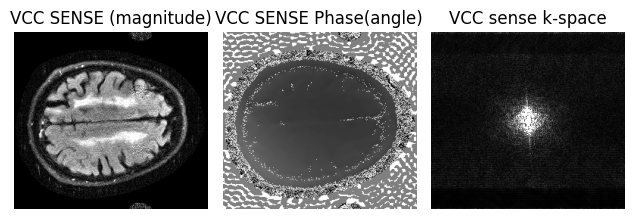

In [12]:
# VCC-SENSE

coilc_P = coilc * Pc

flip_maskc = torch.roll(maskc.flip([-1,-2]), [((nx+1)%2), ((ny+1)%2) ], dims=(-1,-2))
datc_vcc = torch.cat((datc, torch.roll(datc.conj().flip([-1,-2]), [((nx+1)%2), ((ny+1)%2) ], dims=(-1,-2))  ), dim=1)



def Ac_vcc(m):
    y1 = maskc * ft2c(coilc_P * m)
    y2 = flip_maskc * ft2c( coilc_P.conj() * m)

    return torch.cat((y1,y2), dim=1)

# Its Hermitian
def Ahc_vcc(x):
    y1 = x[:,:nc]
    y2 = x[:,nc:]

    z1 = (torch.conj(coilc_P)*ift2c(maskc*y1)).sum(1)
    z2 = (coilc_P*ift2c(flip_maskc*y2)).sum(1)

    # z2 = 0
    return z1 + z2


print('VCC-SENSE')


x = torch.zeros([1,1,nx,ny]).to(device)

r = Ahc_vcc(datc_vcc) - Ahc_vcc(Ac_vcc(x)) # y - UFSx
print(r.shape)
p = r # residue Matrix
rsold = torch.norm(r, 'fro') **2


for it in range(50): # Training x
    z = Ahc_vcc(Ac_vcc(p))
    alpha = rsold / inner_c(p, z)
    x = x + alpha * p
    r = r - alpha * z
    rsnew = torch.norm(r, 'fro')**2

    if (it) % 10 == 0:
        print('iter', it, ', residue',np.sqrt(rsnew.cpu().numpy()))

    if torch.sqrt(rsnew) < 1e-6:
        break
    p = r + (rsnew / rsold) * p
    rsold = rsnew


mag = x.squeeze().cpu().numpy()
vcc_sense = mag * Pe

NRMSE = LA.norm(ideal - vcc_sense) / LA.norm(ideal)
print("Error:", NRMSE)

print('VCC-SENSE results')
plt.subplot(131), showImg(abs(vcc_sense), name = 'VCC SENSE (magnitude)')
plt.subplot(132), showImg(np.angle(vcc_sense),v_min = -np.pi , v_max = np.pi, name = 'VCC SENSE Phase(angle)')
plt.subplot(133), showImg(abs(ft2_np(vcc_sense)), name = 'VCC sense k-space')
plt.show()

# error


In [13]:
def run_vcc_sense_cg(prior=0, w = 0, iter = 50):
  x = Ahc_vcc(datc_vcc).to(device)
  r = (Ahc_vcc(datc_vcc) - Ahc_vcc(Ac_vcc(x))) + w * (prior - x)
  p = r
  rsold = torch.norm(r, 'fro') **2
  for it in range(iter):
      z = Ahc_vcc(Ac_vcc(p)) + w * p
      alpha = rsold / inner_c(p, z)
      x = x + alpha * p
      r = r - alpha * z
      rsnew = torch.norm(r, 'fro')**2

      if torch.sqrt(rsnew) < 1e-6:
          break
      p = r + (rsnew / rsold) * p
      rsold = rsnew

  recon = x.squeeze().cpu().numpy()[...,None]
  display_all(abs(recon))
  sense = recon
  return sense

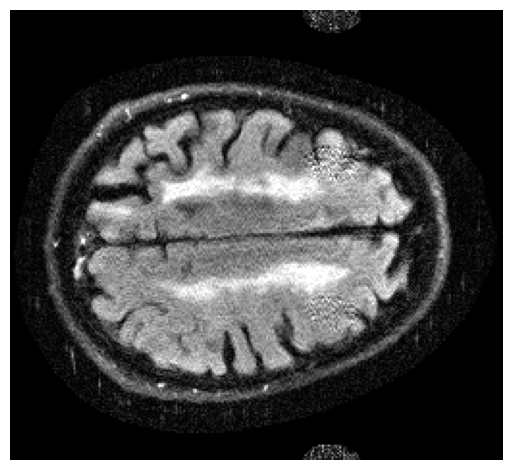

Initial NRMSE 0.19015134150238233


In [14]:
# Initialization
in_ch = 24
out_ch = 2
model = GenNet(in_ch, out_ch).to(device)
input = torch.rand(1, in_ch, nx//32 + (nx%32 >0), ny//32 + (ny%32 >0)).to(device)


target_to_DIP = run_vcc_sense_cg(w=0)
result = target_to_DIP.squeeze() * Pe
NRMSE = LA.norm(ideal - result) / LA.norm(ideal)
print("Initial NRMSE", NRMSE)


In [15]:
# Proposed Method

for i in range(15):
  prev_target_to_DIP = target_to_DIP
  prior, loss = run_GenNet(model, input, target_to_DIP, iterations = 1001,lr=1e-3)
  target_to_DIP = run_vcc_sense_cg(prior = prior, w = 5 * 1e-1)

  result = target_to_DIP.squeeze() * Pe
  NRMSE = LA.norm(ideal - result) / LA.norm(ideal)
  print("current NRMSE", NRMSE)

  if LA.norm(prev_target_to_DIP - target_to_DIP) / LA.norm(target_to_DIP) < 1e-2:
    break

Output hidden; open in https://colab.research.google.com to view.

Proposed Method NRMSE: 0.14031766922144695
Proposed Method


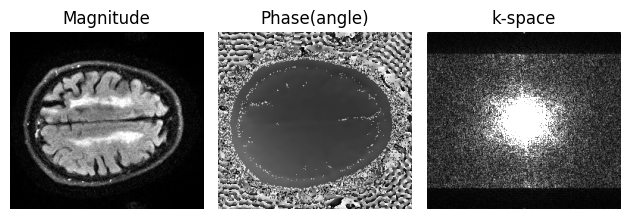

In [16]:
# Results
result = target_to_DIP.squeeze() * Pe
NRMSE = LA.norm(ideal - result) / LA.norm(ideal)
print("Proposed Method NRMSE:", NRMSE)

show_results(result, 'Proposed Method')

Gold Standard


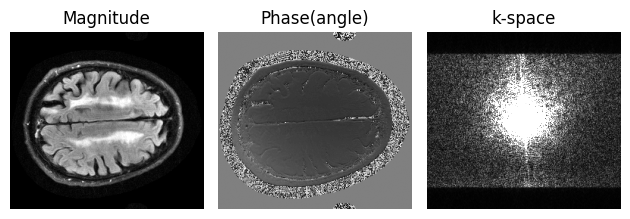

In [17]:
show_results(ideal, 'Gold Standard')